In [10]:
from IPython.display import display
from PIL import Image, features

import numpy as np
import torch

In [11]:
image = Image.open('../datasets/ethereal/stereo-ball.png')
# display(image)

In [12]:
image = image.resize((image.width * 2, image.height * 2), Image.NEAREST)
bands = image.split()
image_data = np.expand_dims(np.asarray([np.asarray(band) for band in bands]), 0)

display(image_data.shape)

(1, 3, 372, 1000)

In [13]:
def cencus_transform(img):
    t = torch.tensor(img)
    n, c, h, w = t.size()
    res = torch.zeros((n, c, h - 2, w - 2), dtype=torch.uint8)
    targets = t[:, :, 1:h - 1, 1: w - 1]
    offsets = [(u, v) for v in range(3) for u in range(3) if not u == v == 1]
    for u, v in offsets:
        res = (res << 1) | (t[:, :, u:u + h - 2, v:v + w - 2] >= targets).byte()

    return torch.nn.functional.pad(res.float(), (1, 1, 1, 1), mode='reflect').type(torch.uint8)

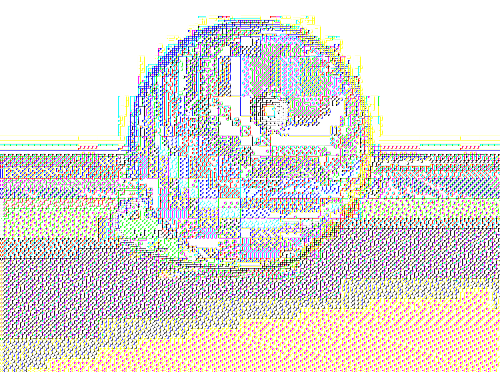

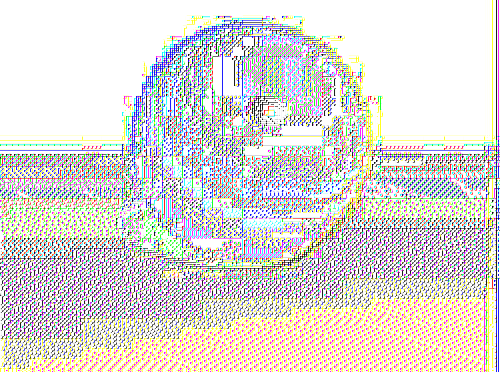

In [14]:
image_data_t = cencus_transform(image_data)
# display(
#     image_data[0][0],
#     image_data_t[0][0].numpy()
# )

n, c, h, w = image_data_t.size()
split_at = int(w/2)
left_data = image_data_t[:, :, :, :split_at]
right_data = image_data_t[:, :, :, split_at:]

left = Image.merge('RGB', (
    Image.fromarray(left_data[0][0].numpy()),
    Image.fromarray(left_data[0][1].numpy()),
    Image.fromarray(left_data[0][2].numpy()),
))

right = Image.merge('RGB', (
    Image.fromarray(right_data[0][0].numpy()),
    Image.fromarray(right_data[0][1].numpy()),
    Image.fromarray(right_data[0][2].numpy()),
))

display(left, right)

tensor(0, dtype=torch.uint8)

tensor(255, dtype=torch.uint8)

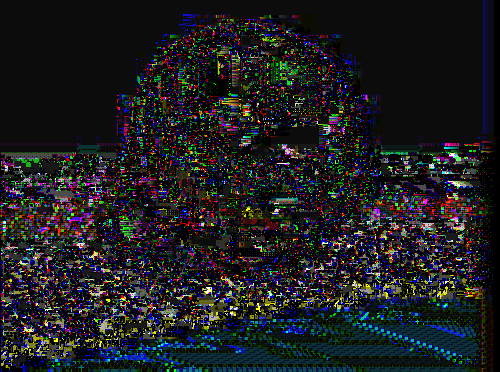

In [15]:
def get_depth_map(img1, img2, pattern_size=2, threshold=20):
    area_size = 2
    b, c, h, w = img1.shape
    depth_map = torch.zeros((b, c, h - 1, w - 1), dtype=torch.uint8)
    areas_img1 = img1.unfold(2, area_size, 1).unfold(3, area_size, 1)
    areas_img2 = img2.unfold(2, area_size, 1).unfold(3, area_size, 1)
    for i in range(21):
        left_slice = areas_img1[:, :, :, :(-i or None)]
        right_slice = areas_img2[:, :, :, i:]
        matching_areas = torch.eq(left_slice, right_slice)
        areas = matching_areas.reshape(b, c, h - 1, w - 1 - i, -1)
        matches = torch.all(areas.bool(), dim=-1).to(dtype=torch.uint8) * i
        depth_map_slice = depth_map[:, :, :, :(-i or None)]
        depth_map[:, :, :, :(-i or None)] = torch.where(depth_map_slice == 0, matches, depth_map_slice)
    return torch.nn.functional.pad(depth_map.float(), (0, 1, 0, 1), mode='reflect')

depth_map = get_depth_map(left_data, right_data)
rescaled = (depth_map - 0) * (255 - 0) / (20 - 0) + 0
rescaled = torch.clamp(rescaled, 0, 255)
rescaled = rescaled.type(torch.uint8)

display(rescaled.min(), rescaled.max())
depth_map_image = Image.merge('RGB', (
    Image.fromarray(rescaled[0][0].numpy()),
    Image.fromarray(rescaled[0][1].numpy()),
    Image.fromarray(rescaled[0][2].numpy()),
))

display(depth_map_image)

In [19]:
depth_maps = rescaled.numpy()
b, c, h, w = rescaled.shape

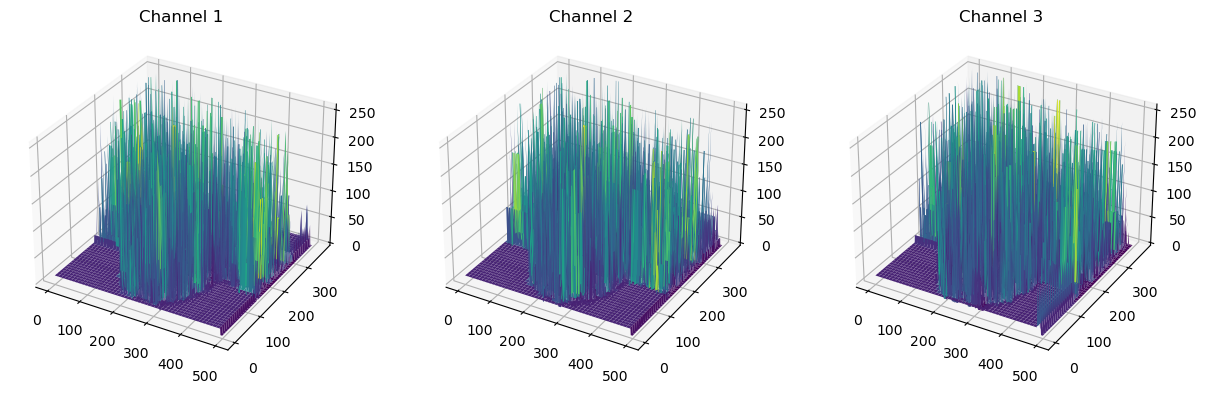

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot for each channel
fig = plt.figure(figsize=(15, 5))

for channel in range(c):
    ax = fig.add_subplot(1, c, channel + 1, projection='3d')
    x, y = np.meshgrid(range(w), range(h))
    z = depth_maps[0, channel]

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_title(f'Channel {channel + 1}')

plt.show()

In [22]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper
from bokeh.layouts import row

# Initialize Bokeh
output_notebook()

# Create a Bokeh plot for each channel
plots = []

for channel in range(c):
    plot = figure(
        title=f'Channel {channel + 1}',
        x_range=(0, w),
        y_range=(0, h),
        toolbar_location=None,
        plot_width=500,
        plot_height=400
    )

    color_mapper = LinearColorMapper(palette="Viridis256", low=depth_maps.min(), high=depth_maps.max())
    plot.image(image=[depth_maps[0, channel]], x=0, y=0, dw=w, dh=h, color_mapper=color_mapper)

    plots.append(plot)
    
# Wrap the figures in a row layout
layout = row(plots)

show(layout)

Loading BokehJS ...

In [ ]:
torch.__version__

In [53]:
import torch
import torch.nn as nn

# Example tensor
A = torch.randn(1, 3, 100, 200)

# Using torch.nn.Unfold
unfold_layer = nn.Unfold(kernel_size=(2, 2), dilation=(1, 1), padding=1, stride=(1, 1))
unfolded_tensor_nn = unfold_layer(A)

print(unfolded_tensor_nn.shape)

# Reshape the unfolded tensor to match the format of A.unfold
B1 = unfolded_tensor_nn.view(1, 3, 101, 201, 2, 2)
B2 =  A.unfold(2, 2, 1).unfold(3, 2, 1)
# Print the result

print(torch.equal(B1, B2))
print(A[0, 0, 0:4, 0:4])
print(B1[0, 0, 1, 1])
print(B2[0, 0, 0, 0])

torch.Size([1, 12, 20301])
False
tensor([[ 0.7265, -0.9808,  0.6986,  0.0551],
        [ 0.2435,  1.0222, -0.5310, -0.5288],
        [-0.6017,  0.1418, -0.8952,  0.8481],
        [-0.0622,  0.7616, -0.7198,  0.3475]])
tensor([[ 0.3475,  2.0076],
        [-0.2727,  0.8830]])
tensor([[ 0.7265, -0.9808],
        [ 0.2435,  1.0222]])


In [35]:
# Assuming you have a 6D tensor A of shape [1, 3, 371, 499, 2, 2]
# Create a sample tensor (replace this with your actual tensor)
A = torch.randn(1, 3, 371, 499, 2, 2)
B = A > 0

# Reshape the tensor to combine the last two dimensions
# C = B.view(1, 3, 371, 499, -1)
C = B.reshape(1, 3, 371, 499, -1)

display(A[0, 0, 0, 0])
display(B[0, 0, 0, 0])
display(C[0, 0, 0, 0])

# Check if all elements in the [2, 2] array are truthy
D = torch.all(C.bool(), dim=-1).to(dtype=torch.uint8)

# Print the shape of the result tensor
print(D)

tensor([[-0.5968, -1.0971],
        [-1.4288,  0.9052]])

tensor([[False, False],
        [False,  True]])

tensor([False, False, False,  True])

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 1]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 1, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 1, 0],
          ...,
          [0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)


In [69]:
a = torch.randn(1, 3, 100, 200, 2, 2)
b = a[:, :, 1:, 1:]
c = a[:, :, :(-0 or None), :(-0 or None)]
print(b.shape)
print(c.shape)

torch.Size([1, 3, 99, 199, 2, 2])
torch.Size([1, 3, 100, 200, 2, 2])


In [16]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       1.4.0
aiofiles                      22.1.0
aiohttp                       3.7.4.post0
aiosqlite                     0.18.0
alembic                       1.10.2
altair                        4.2.2
anyio                         3.6.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.2.1
astunparse                    1.6.3
async-generator               1.10
async-timeout                 3.0.1
attrs                         22.2.0
Babel                         2.12.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.12.0
bleach                        6.0.0
blinker                       1.5
bokeh                         2.4.3
boltons                       23.0.0
Bottleneck                    1.3.7
brotlipy                      0.7.0
cached-property               1.5.2
cacheto